In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

from yellowbrick.cluster import SilhouetteVisualizer
from tqdm import tqdm # progress bar for iterations

In [ ]:
# read ml-100k/u.data to pandas without timestamp column, user_id as index, movie_id as columns and rating as values
ratings = pd.read_csv('ml-100k/u.data', sep='\t', header=None, usecols=[0, 1, 2], names=['user_id', 'movie_id', 'rating'])
movies = pd.read_csv('ml-100k/u.item', sep='|', header=None, usecols=[0, 1], names=['movie_id', 'movie_name'], encoding='latin-1')
users = ratings.pivot(index='user_id', columns='movie_id', values='rating').fillna(0)

# sort users by number of nonzero columns
users = users.reindex(users.astype(bool).sum(axis=1).sort_values(ascending=False).index)

# select top 120 users
users = users[:120]
print('users.shape:', users.shape)

# remove movies watched by less then 50 people
users = users.loc[:, users.astype(bool).sum(axis=0) >= 50]

# train test split 9:1
train = users.iloc[:int(users.shape[0] * 0.9), :]
print('train.shape:', train.shape)
test = users.iloc[int(users.shape[0] * 0.9):, :]
print('test.shape:', test.shape)

print('users.shape:', users.shape)

users.shape: (120, 1682)
train.shape: (108, 258)
test.shape: (12, 258)
users.shape: (120, 258)


100%|██████████| 30/30 [00:07<00:00,  3.85it/s]


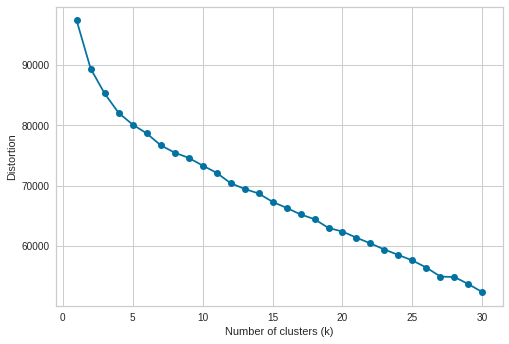

In [ ]:
# elbow method to find the optimal k
distortions = []
for i in tqdm(range(1, 31)):
    km = KMeans(n_clusters=i, init='k-means++', n_init=10, max_iter=300, random_state=0)
    km.fit(train)
    distortions.append(km.inertia_)


plt.plot(range(1, 31), distortions, marker='o')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Distortion')
plt.show()

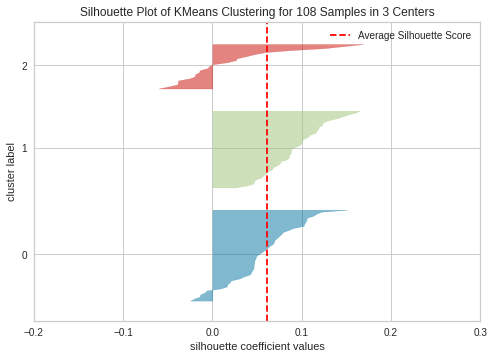

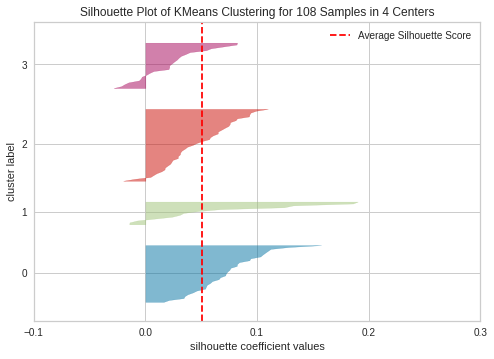

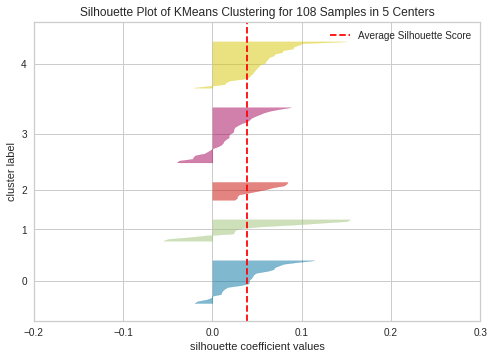

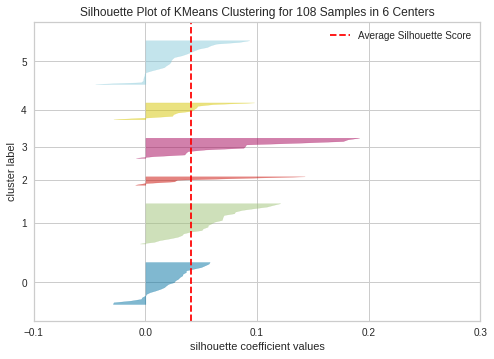

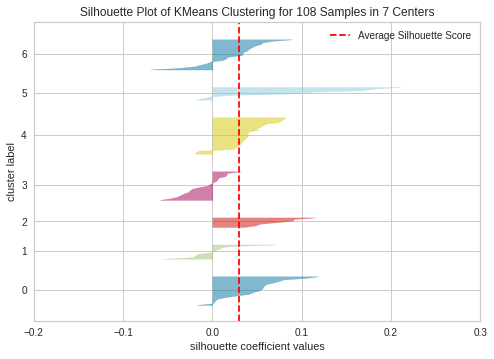

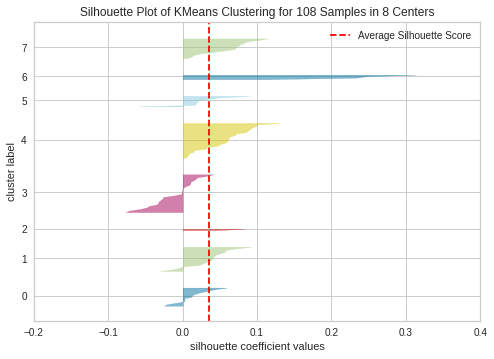

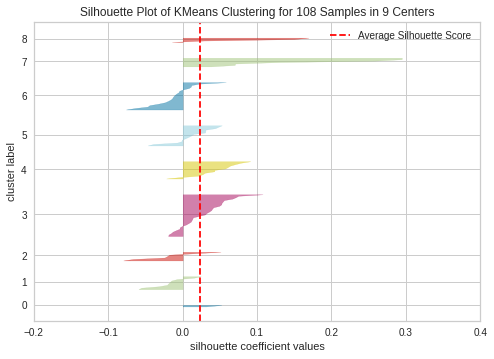

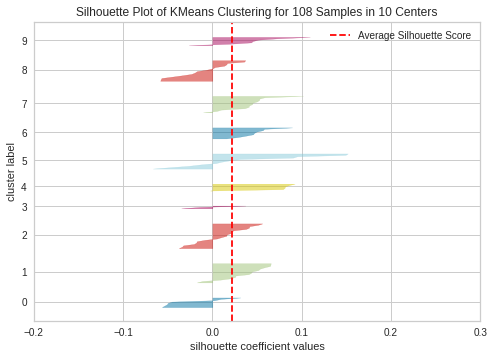

In [ ]:
# silhouette method to find the optimal k
for i in range(3, 11):
    km = KMeans(n_clusters=i, init='k-means++', n_init=10, max_iter=300, random_state=0)
    visualizer = SilhouetteVisualizer(km, colors='yellowbrick')
    visualizer.fit(train)
    visualizer.show()

In [ ]:
# construct kmeans with k=6
km = KMeans(n_clusters=6, init='k-means++', n_init=10, max_iter=300, random_state=0)

# fit kmeans
km.fit(train)

def get_recommendations(user):
    # find the cluster user belongs to
    print(f"Recommendations for user {user.name}:")
    cluster_id = km.predict(user.to_numpy().reshape(1, -1))
    cluster = train[km.labels_ == cluster_id]

    # find columns with zero values in user_id row
    unrated_movies = train.columns[user == 0]

    # find highest rated movies in cluster that user_id has not rated
    recommendations = cluster[unrated_movies].mean().sort_values(ascending=False).head(10)
    recommendations = movies.iloc[recommendations.index]['movie_name'].to_list()
    return recommendations

In [ ]:
recommendations = get_recommendations(test.iloc[0])
print(*recommendations, sep = "\n")

Recommendations for user 345:
2001: A Space Odyssey (1968)
Restoration (1995)
Maltese Falcon, The (1941)
Leaving Las Vegas (1995)
Blues Brothers, The (1980)
It Happened One Night (1934)
Monty Python's Life of Brian (1979)
This Is Spinal Tap (1984)
Kama Sutra: A Tale of Love (1996)
Dead Man Walking (1995)
